# Create media designs using ART

We use ART to provide suggested designs for media components for which to get phenotypic data.  We will use absorbance at 340nm as assay for this experiment.

For DBTL 8 we create X designs from an exploratory mode with $\alpha=1.$ and relative recommendations distance X%, X designs from the exploitation mode ($\alpha=0$) and relative recommendations distance X%, and 1 design being close to the standard media as a control, totalling 16 designs in triplicates.


Tested using **ART Prod** kernel on skynet.ese.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `Putida_media_bounds_extended.csv`
- `standard_recipe_concentrations_extended.csv`
- EDD study slug(s)

**File generated by running this notebook**
- 
-
-

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [1]:
import os
import sys
import re
import warnings
import pickle
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy



Import ART

In [2]:
sys.path.append('../')        # Make sure this is the location for the ART library 
sys.path.append('../media_compiler')

from art.core import RecommendationEngine 
import art.plot as plot
import art.utility as utils
import edd_utils as eddu
from core import designs_pairwise
import warning_utils
warning_utils.filter_end_user_warnings()



/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## User parameters

In [3]:
CYCLE = '4.2'

user_params = {
    'bounds_file': f'../flaviolin data/Putida_media_bounds_extended_nocacl2.csv',
    'output_dir': f'../flaviolin data/DBTL{CYCLE}', # Folder for output files,
    'standard_media_file': '../flaviolin data/standard_recipe_concentrations.csv', #location of the standard media recipe
    'study_slug_1': 'combinatorial-media-for-flaviolin-repeats-dbt-507a', #DBTL1
    'study_slug_2': 'combinatorial-media-for-flaviolin-repeats-dbtl-21',#DBTL2
    'study_slug_3': 'combinatorial-media-for-flaviolin-repeats-dbt-59a2',#DBTL3
    'edd_server': 'edd.jbei.org',
    'username': 'azournas',
}

In [4]:
os.makedirs(user_params['output_dir'], exist_ok=True) #make the directory to store the output files

### Defining media components and the number of instances (designs) to be created

Specify which components to explore:

In [5]:
user_params['components'] = [
    'H3BO3[mM]',
    #'Glucose[mM]',
    'K2SO4[mM]',
    'K2HPO4[mM]',
    'FeSO4[mM]',
    'NH4Cl[mM]',
    'MgCl2[mM]',
    'NaCl[mM]',
    '(NH4)6Mo7O24[mM]',
    'CoCl2[mM]',
    'CuSO4[mM]',
    'MnSO4[mM]',
    'ZnSO4[mM]',
    # 'CaCl2[mM]'    
]

user_params['response'] = 'OD340' #this will be the parameter we will maximize

Here we specify how many instances (designs) we want to create and how many replicates:

In [6]:
user_params['n_instances_explor'] = 5 # number of exploration recommendations
user_params['n_instances_exploit'] = 10 # number of exploitation recommendations
user_params['n_replicates'] = 3 # number of replicates generated in the biolector plate.
user_params['seed'] = 42
#The biolector plate we are using here is a 48-well plate. For 3 replicates, the total number of conditions tested will need to be 48/3 = 16. In this case 13 exploitation, 2 exploration and 1 standard. 

Lastly we specify the exploration and exploitation parameters (alpha) and the number of iterations that Parallel tempering will go through

In [8]:
user_params['alpha_explor'] = 1
user_params['alpha_exploit'] = 0 
user_params['n_iter'] = 1e5

In [9]:
user_params['scale_input_vars'] = False
user_params['cross_val'] = True
user_params['recommend'] = False


## Load the data

In [10]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

In [11]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']
study_slug_3 = user_params['study_slug_3']


edd_server = user_params['edd_server']
username = user_params['username']

In [12]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
    load_from_disk = True
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')    
    load_from_disk = False

Password for azournas:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


In [13]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
    df_3 = eddu.export_study(session, study_slug_3, edd_server=edd_server)
    load_from_disk = False
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')
    load_from_disk = True

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [14]:

if load_from_disk:
    df_1 = pd.read_csv('../flaviolin data/df_dbtl1-repeat.csv')
    df_2 = pd.read_csv('../flaviolin data/df_dbtl2-repeat.csv')
    df_3 = pd.read_csv('../flaviolin data/df_dbtl2-repeat.csv')
else:
    df_1.to_csv('../flaviolin data/df_dbtl1-repeat.csv')
    df_2.to_csv('../flaviolin data/df_dbtl2-repeat.csv')
    df_3.to_csv('../flaviolin data/df_dbtl3-repeat.csv')



In [18]:
df_1.head(46)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,198207,Combinatorial media for flaviolin repeats DBTL 1,198208,3d6e41f8-1e53-4e5e-9d0c-bd05f54610d1,C1_WA1_A3-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198256,C1_WA1_A3-R1,NaN,OD340,0,NaN,0.2076,48.0
1,198207,Combinatorial media for flaviolin repeats DBTL 1,198209,933f7301-9067-4487-bf8f-b1c866d6230c,C1_WA1_A3-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198257,C1_WA1_A3-R2,NaN,OD340,0,NaN,0.2149,48.0
2,198207,Combinatorial media for flaviolin repeats DBTL 1,198210,f380d449-2b06-4931-bfbd-6b9521a2082c,C1_WA1_A3-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198258,C1_WA1_A3-R3,NaN,OD340,0,NaN,0.2124,48.0
3,198207,Combinatorial media for flaviolin repeats DBTL 1,198211,23f9153e-42f9-478b-a8b7-99ea3056ad3c,C1_WA4_A6-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198259,C1_WA4_A6-R1,NaN,OD340,0,NaN,0.1955,48.0
4,198207,Combinatorial media for flaviolin repeats DBTL 1,198212,a1e39a42-d040-4003-a6b0-0399da9acb3f,C1_WA4_A6-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198260,C1_WA4_A6-R2,NaN,OD340,0,NaN,0.1859,48.0
5,198207,Combinatorial media for flaviolin repeats DBTL 1,198213,f0c8b6cb-571b-472e-be47-24c1e55e552f,C1_WA4_A6-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198261,C1_WA4_A6-R3,NaN,OD340,0,NaN,0.1859,48.0
6,198207,Combinatorial media for flaviolin repeats DBTL 1,198214,f77bab33-c64e-4302-b10d-dc228de163de,C1_WA7_B1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198262,C1_WA7_B1-R1,NaN,OD340,0,NaN,0.1986,48.0
7,198207,Combinatorial media for flaviolin repeats DBTL 1,198215,49157e35-221d-4652-8aa9-309d514dce30,C1_WA7_B1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198263,C1_WA7_B1-R2,NaN,OD340,0,NaN,0.2294,48.0
8,198207,Combinatorial media for flaviolin repeats DBTL 1,198216,e8875c75-a18a-4cc1-ae39-feaf1bd936e3,C1_WA7_B1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198264,C1_WA7_B1-R3,NaN,OD340,0,NaN,0.1602,48.0
9,198207,Combinatorial media for flaviolin repeats DBTL 1,198217,83949df4-5a7d-457f-9d2c-e0efbaa9f809,C1_WB2_B4-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198265,C1_WB2_B4-R1,NaN,OD340,0,NaN,0.3320,48.0


In [19]:
df_2.head(46)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,204620,Combinatorial media for flaviolin repeats DBTL...,204621,ba2d4843-698f-46f8-8c82-be7208f5a4cb,C2.1_WA1_A3-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204669,C2.1_WA1_A3-R1,NaN,OD340,0,NaN,0.2099,48.0
1,204620,Combinatorial media for flaviolin repeats DBTL...,204622,bfdb931b-d3e4-470d-b717-6f437abebd63,C2.1_WA1_A3-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204670,C2.1_WA1_A3-R2,NaN,OD340,0,NaN,0.2267,48.0
2,204620,Combinatorial media for flaviolin repeats DBTL...,204623,a9ce16a3-6d2e-4083-b397-7b7e89600424,C2.1_WA1_A3-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204671,C2.1_WA1_A3-R3,NaN,OD340,0,NaN,0.2334,48.0
3,204620,Combinatorial media for flaviolin repeats DBTL...,204624,eaaffd6f-90e9-4ddb-afe6-014f2aa4ff52,C2.1_WA4_A6-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204672,C2.1_WA4_A6-R1,NaN,OD340,0,NaN,0.4625,48.0
4,204620,Combinatorial media for flaviolin repeats DBTL...,204625,acd74273-b6de-4b35-a45e-1bb06df7c969,C2.1_WA4_A6-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204673,C2.1_WA4_A6-R2,NaN,OD340,0,NaN,0.5259,48.0
5,204620,Combinatorial media for flaviolin repeats DBTL...,204626,cde3a6c8-fd07-4145-aaaf-ae1d262f085a,C2.1_WA4_A6-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204674,C2.1_WA4_A6-R3,NaN,OD340,0,NaN,0.5059,48.0
6,204620,Combinatorial media for flaviolin repeats DBTL...,204627,87014b10-5371-404b-90d7-b044eefe5f33,C2.1_WA7_B1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204675,C2.1_WA7_B1-R1,NaN,OD340,0,NaN,0.0072,48.0
7,204620,Combinatorial media for flaviolin repeats DBTL...,204628,9154da3a-e904-4d37-8ead-803e13728f24,C2.1_WA7_B1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204676,C2.1_WA7_B1-R2,NaN,OD340,0,NaN,0.2218,48.0
8,204620,Combinatorial media for flaviolin repeats DBTL...,204629,44b57194-d68f-4798-9c53-fe1fbd1128fe,C2.1_WA7_B1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204677,C2.1_WA7_B1-R3,NaN,OD340,0,NaN,0.1616,48.0
9,204620,Combinatorial media for flaviolin repeats DBTL...,204630,0fb8e9e6-23d7-4316-929c-fbdd8fdbe894,C2.1_WB2_B4-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204678,C2.1_WB2_B4-R1,NaN,OD340,0,NaN,0.3330,48.0


In [20]:
df_3.head(46)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,198110,Combinatorial media for flaviolin repeats DBTL...,198111,6c4d2b6f-80c4-40ff-b0c2-d115cfc19be8,C3.1_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198159,C3.1_WA1_C1-R1,NaN,OD340,0,NaN,0.5093,48.0
1,198110,Combinatorial media for flaviolin repeats DBTL...,198112,6e59c076-36b6-46be-bb7e-c517352705fb,C3.1_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198160,C3.1_WA1_C1-R2,NaN,OD340,0,NaN,0.4785,48.0
2,198110,Combinatorial media for flaviolin repeats DBTL...,198113,e507cff3-1d66-4d40-81b8-fa0f39514aa7,C3.1_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198161,C3.1_WA1_C1-R3,NaN,OD340,0,NaN,0.4685,48.0
3,198110,Combinatorial media for flaviolin repeats DBTL...,198114,0d6f9efd-91bf-4111-8941-d3de11049209,C3.1_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198162,C3.1_WD1_F1-R1,NaN,OD340,0,NaN,0.4412,48.0
4,198110,Combinatorial media for flaviolin repeats DBTL...,198115,ad9e106b-8f74-43d7-8add-e71c9e379458,C3.1_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198163,C3.1_WD1_F1-R2,NaN,OD340,0,NaN,0.4584,48.0
5,198110,Combinatorial media for flaviolin repeats DBTL...,198116,fe530442-2df1-4696-a73e-ccb4eca289ae,C3.1_WD1_F1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198164,C3.1_WD1_F1-R3,NaN,OD340,0,NaN,0.4581,48.0
6,198110,Combinatorial media for flaviolin repeats DBTL...,198117,84935656-c3b6-4602-991d-21af0befcd0d,C3.1_WA2_C2-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198165,C3.1_WA2_C2-R1,NaN,OD340,0,NaN,0.4547,48.0
7,198110,Combinatorial media for flaviolin repeats DBTL...,198118,3c1a22f2-409f-4c71-a0da-62f856dae7e0,C3.1_WA2_C2-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198166,C3.1_WA2_C2-R2,NaN,OD340,0,NaN,0.4378,48.0
8,198110,Combinatorial media for flaviolin repeats DBTL...,198119,08aed7c5-2e37-4899-adc9-caa7982a5bd7,C3.1_WA2_C2-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198167,C3.1_WA2_C2-R3,NaN,OD340,0,NaN,0.4529,48.0
9,198110,Combinatorial media for flaviolin repeats DBTL...,198120,25883894-4e3f-4a68-ad67-84cafc081aba,C3.1_WD2_F2-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198168,C3.1_WD2_F2-R1,NaN,OD340,0,NaN,0.4278,48.0


In [21]:
outliers = ['C1_WB8_C2-R1','C2.1_WA7_B1-R1','C2.1_WB8_C2-R1','C2.1_WF6_F8-R2','C3.1_WA5_C5-R3']


## Preprocess the data

Concatenate the six studies:

In [29]:
df = pd.concat([df_1, df_2, df_3])

In [30]:
df = df.drop(df.loc[df['Line Name'].isin(outliers)].index)

In [31]:
df.loc[df['Line Name'].isin(outliers)]

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours


In [32]:
# df_control_vals = df[['Line Name','Control_Val']]

In [33]:
df.head()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,198207,Combinatorial media for flaviolin repeats DBTL 1,198208,3d6e41f8-1e53-4e5e-9d0c-bd05f54610d1,C1_WA1_A3-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198256,C1_WA1_A3-R1,NaN,OD340,0,NaN,0.2076,48.0
1,198207,Combinatorial media for flaviolin repeats DBTL 1,198209,933f7301-9067-4487-bf8f-b1c866d6230c,C1_WA1_A3-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198257,C1_WA1_A3-R2,NaN,OD340,0,NaN,0.2149,48.0
2,198207,Combinatorial media for flaviolin repeats DBTL 1,198210,f380d449-2b06-4931-bfbd-6b9521a2082c,C1_WA1_A3-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198258,C1_WA1_A3-R3,NaN,OD340,0,NaN,0.2124,48.0
3,198207,Combinatorial media for flaviolin repeats DBTL 1,198211,23f9153e-42f9-478b-a8b7-99ea3056ad3c,C1_WA4_A6-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198259,C1_WA4_A6-R1,NaN,OD340,0,NaN,0.1955,48.0
4,198207,Combinatorial media for flaviolin repeats DBTL 1,198212,a1e39a42-d040-4003-a6b0-0399da9acb3f,C1_WA4_A6-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198260,C1_WA4_A6-R2,NaN,OD340,0,NaN,0.1859,48.0


In [34]:
df.tail()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
43,198110,Combinatorial media for flaviolin repeats DBTL...,198154,ffe3c57e-d895-495a-b23a-acd8f3d75a00,C3.1_WA8_C8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198202,C3.1_WA8_C8-R2,NaN,OD340,0,NaN,0.4377,48.0
44,198110,Combinatorial media for flaviolin repeats DBTL...,198155,d7987328-2002-43a9-872b-6ff21f2f3f96,C3.1_WA8_C8-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198203,C3.1_WA8_C8-R3,NaN,OD340,0,NaN,0.4634,48.0
45,198110,Combinatorial media for flaviolin repeats DBTL...,198156,ef8f1e11-d2c1-49f7-a9bd-e7403bd5eb91,C3.1_WD8_F8-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198204,C3.1_WD8_F8-R1,NaN,OD340,0,NaN,0.2499,48.0
46,198110,Combinatorial media for flaviolin repeats DBTL...,198157,eee23eda-1754-4f7d-bc9f-3ac8a7f1eaa4,C3.1_WD8_F8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198205,C3.1_WD8_F8-R2,NaN,OD340,0,NaN,0.2753,48.0
47,198110,Combinatorial media for flaviolin repeats DBTL...,198158,f0ef05c6-61d2-4bc9-add4-706a0a56fce6,C3.1_WD8_F8-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198206,C3.1_WD8_F8-R3,NaN,OD340,0,NaN,0.2692,48.0


In [35]:
df['Study Name'].unique()

array(['Combinatorial media for flaviolin repeats DBTL 1',
       'Combinatorial media for flaviolin repeats DBTL 2.1',
       'Combinatorial media for flaviolin repeats DBTL 3.1'], dtype=object)

Drop unnecessary columns:

In [37]:
df = df.loc[:,['Line Name', 'Value','Measurement Type','Line Description']]


Pivot the dataframe: This will generate a line for each sample with the corresponding OD600 and OD340 values

In [38]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Measurement Type", values="Value")#, 'Control_Val'])
df.reset_index(inplace=True)


In [39]:
df.head()

Measurement Type,Line Name,Line Description,OD340
0,C1_WA1_A3-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.2076
1,C1_WA1_A3-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.2149
2,C1_WA1_A3-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.2124
3,C1_WA4_A6-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.1955
4,C1_WA4_A6-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.1859


Drop OD600 since we are not using it

### Adding media information to the data frame

Add columns for each component:

In [40]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None
# df['CaCl2[mM]'] = 0 # add a column for CaCl2. 
#CaCl2 is only added to DBTL 7 and 8 so it doesn't exist in the line descriptions for DBTL 1-6. 
#Concentration of CaCl2 will be 0 for DBTL 1-6

#df['Kan[g/L]'] = None # add a column for Kan. 
#Kan concentration is 0.05 g/l. 
#This is the same concentration for all cases and is not used by ART.
#this is in the Line descriptions only for DBTL8



For every component in the line description assign the right value in each column created previously.

In [41]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (3+c)] = float(value)


df.drop(columns='Line Description', inplace=True)
#df = df.merge(df_control_vals, on='Line Name')
#df['OD340'] = df['OD340']/df['Control_Val']

In [42]:
df

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l]
0,C1_WA1_A3-R1,0.2076,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
1,C1_WA1_A3-R2,0.2149,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
2,C1_WA1_A3-R3,0.2124,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
3,C1_WA4_A6-R1,0.1955,40.0,4.0,0.003918,20.0,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.05
4,C1_WA4_A6-R2,0.1859,40.0,4.0,0.003918,20.0,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,C3.1_WD7_F7-R2,0.5667,40.0,4.0,0.012305,20.0,0.795866,2.123382,0.049167,10.839289,0.510871,386.600976,0.000022,0.000946,0.001125,0.013717,0.001156,0.05
130,C3.1_WD7_F7-R3,0.4280,40.0,4.0,0.012305,20.0,0.795866,2.123382,0.049167,10.839289,0.510871,386.600976,0.000022,0.000946,0.001125,0.013717,0.001156,0.05
131,C3.1_WD8_F8-R1,0.2499,40.0,4.0,0.00409,20.0,0.3158,1.395181,0.009462,9.766629,0.543018,52.665395,0.00003,0.000309,0.000103,0.000764,0.000106,0.05
132,C3.1_WD8_F8-R2,0.2753,40.0,4.0,0.00409,20.0,0.3158,1.395181,0.009462,9.766629,0.543018,52.665395,0.00003,0.000309,0.000103,0.000764,0.000106,0.05


### Include Yield and clean up the training data

Include the Yield column:

In [43]:
# df['OD340'] = df['OD340']*1000

In [45]:
df.head()

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l]
0,C1_WA1_A3-R1,0.2076,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
1,C1_WA1_A3-R2,0.2149,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
2,C1_WA1_A3-R3,0.2124,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
3,C1_WA4_A6-R1,0.1955,40.0,4.0,0.003918,20.0,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.05
4,C1_WA4_A6-R2,0.1859,40.0,4.0,0.003918,20.0,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.05


In [46]:
df.tail()

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l]
129,C3.1_WD7_F7-R2,0.5667,40.0,4.0,0.012305,20.0,0.795866,2.123382,0.049167,10.839289,0.510871,386.600976,0.000022,0.000946,0.001125,0.013717,0.001156,0.05
130,C3.1_WD7_F7-R3,0.4280,40.0,4.0,0.012305,20.0,0.795866,2.123382,0.049167,10.839289,0.510871,386.600976,0.000022,0.000946,0.001125,0.013717,0.001156,0.05
131,C3.1_WD8_F8-R1,0.2499,40.0,4.0,0.00409,20.0,0.3158,1.395181,0.009462,9.766629,0.543018,52.665395,0.00003,0.000309,0.000103,0.000764,0.000106,0.05
132,C3.1_WD8_F8-R2,0.2753,40.0,4.0,0.00409,20.0,0.3158,1.395181,0.009462,9.766629,0.543018,52.665395,0.00003,0.000309,0.000103,0.000764,0.000106,0.05
133,C3.1_WD8_F8-R3,0.2692,40.0,4.0,0.00409,20.0,0.3158,1.395181,0.009462,9.766629,0.543018,52.665395,0.00003,0.000309,0.000103,0.000764,0.000106,0.05


Remove all the low performing strains

bar plot the training data

Define the control lines. In DBTL 1 and 2, controls were wells F5 to F8. In other DBTL cycles the control is stored in the last column (D8, E8, F8).

In [47]:
control_lines = df[df['Line Name'].str.find('_F8') > 0]

#control_lines = control_lines.append(df[df['Line Name'].str.find('WD8_F8') > 0])

control_lines = pd.concat([control_lines, df[df['Line Name'].str.find('WD8_F8') > 0]], ignore_index=True)

### Convert the data to EDD format

Pivot the dataframe back to EDD format, including all the components names and protocols:

In [48]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']

### OD340 of the highest performing strains is at 0.7. 
### I multiply the data by 1000 to bring it up to ~700 to improve parallel tempering performance
df_stacked.loc[df_stacked["Measurement Type"] == "OD340", 'Value'] = df_stacked.loc[df_stacked["Measurement Type"] == "OD340", 'Value'] 

df_stacked


,Line Name,Measurement Type,Value
0,C1_WA1_A3-R1,OD340,0.2076
1,C1_WA1_A3-R1,MOPS[mM],40.0
2,C1_WA1_A3-R1,Tricine[mM],4.0
3,C1_WA1_A3-R1,H3BO3[mM],0.019871
4,C1_WA1_A3-R1,Glucose[mM],20.0
...,...,...,...
2273,C3.1_WD8_F8-R3,CoCl2[mM],0.000309
2274,C3.1_WD8_F8-R3,CuSO4[mM],0.000103
2275,C3.1_WD8_F8-R3,MnSO4[mM],0.000764
2276,C3.1_WD8_F8-R3,ZnSO4[mM],0.000106


## Define functions we will use to train art, generate recommendations and plot the results

In [49]:
def hist_recommendations(df_rec, hist_components):
    n_plots = len(hist_components)
    n_cols = 3
    n_rows = (n_plots + 1) // n_cols    
    fig, axs = plt.subplots(n_rows,n_cols, figsize = (7,15),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 0.2, wspace=0.3)
    axs = axs.ravel()
    #axs.update(wspace=0.5, hspace=0.5)
    for iplot in range(n_plots):
        v = hist_components[iplot]
        axs[iplot].hist(df_rec[v])
        axs[iplot].set_title(v)
    

In [50]:
def plot_train_recs(df_train, df_rec, train_label, rec_label):
    names_train = df_train['Line Name']
    y_train = df_train[train_label]

    names_rec = [f'rec{i}' for i in range(len(df_target))]
    y_rec = df_target[rec_label]
    fig, ax = plt.subplots()
    ax.bar(names_train, y_train, color='blue')
    ax.bar(names_rec, y_rec, color='red')

In [51]:
def train_art(df, user_params,art_filename):
    art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds': utils.read_table(user_params['bounds_file']), # file with bounds# input variables, i.e. features
    'scale_input_vars': user_params['scale_input_vars'],
    'cross_val': user_params['cross_val'],
    'recommend': user_params['recommend'],
    'output_dir': user_params['output_dir'],  # directory to store this output
    'verbose': 1,
    'num_tpot_models': 4,
    'max_mcmc_cores': 4,
    'seed': user_params['seed'],
    'build_model' : True,
    'recommend' : False
    }
    
    art_params['bounds'] = art_params['bounds'].drop(index=[0,1,3])
    
    art = RecommendationEngine(df=df, **art_params)
    
    art.save()
    
    orig_file_name = f"{art_params['output_dir']}/art.cpkl"
    new_file_name = f"{art_params['output_dir']}/{art_filename}"
    os.rename(orig_file_name, new_file_name)

    return art

In [52]:
def generate_recommendations(art, user_params, draws_filename, alpha, n_recs, rel_rec_distance):
    art.niter = user_params['n_iter']
    #user_params['aplha_exploit'] = 0 
    art.num_recommendations = n_recs # 
    art.rel_rec_distance = rel_rec_distance # Default is 0.2
    art.alpha = alpha 
    draws = art.parallel_tempering_opt()
    art.recommend(draws)
    orig_file_name = f"{user_params['output_dir']}/draws.txt"
    new_file_name = f"{user_params['output_dir']}/{draws_filename}"
    os.rename(orig_file_name, new_file_name)
    return art, draws

In [53]:
def process_and_plot_recommendations(art):
    df_rec = art.recommendations
    df_rec.rename(columns={'OD340': 'OD340_pred'}, inplace=True)

    predicted_mean, predicted_std = art.post_pred_stats(
                df_rec.values[:, :-1]
            ) # posterior predictive statistics: mean and std

    df_rec['OD340_std'] = predicted_std

    df_rec['Label'] = 'exploitation'
    return df_rec

In [54]:
def load_art_get_train_recs(path_to_art):
    with open(path_to_art, "rb") as input_file:
        art = pickle.load(input_file)
    df_train = pd.DataFrame(art.X, columns = art.input_vars)
    df_train[art.response_vars[0]] = art.y
    
    df_rec = art.recommendations
    predicted_mean, predicted_std = art.post_pred_stats(
                df_rec.values[:, :-1]
            ) # posterior predictive statistics: mean and std
    df_rec[art.response_vars[0]+'_pred'] = predicted_mean
    df_rec[art.response_vars[0]+'_pred'] = predicted_std
    return df_train, df_rec
    

In [55]:
def plot_dfs(dfs, cols, labels, xlabel, ylabel, title):
    
    fig, ax = plt.subplots()
    counter = 0
    for i in range(len(dfs)):
        ax.scatter(np.array(range(len(dfs[i][cols[i]])))+counter, dfs[i][cols[i]], label = labels[i])
        counter+=len(dfs[i][cols[i]])
        # ax.bar(dfs[i].index+counter, dfs[i][cols[i]], label = labels[i], width=1)
        # counter+=max(dfs[i].index)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.legend(fontsize=12)
    ax.set_title(title, fontsize = 12)

In [56]:
def main_func(df, user_params):
    #scale_input_vars = 'yes' if user_params['scale_input_vars'] else 'no'        
    art_path = Path(user_params['output_dir'], f'art__scaled_y_{scaling_factor}_no_scaled_inputs_run{run}.pkl')
    draws_path = Path(user_params['output_dir'], f'draws_scaled_x_{scaling_factor}_no_scaled_inputs_run{run}.pkl')
    print(f'run {run}, scaling factor {scaling_factor}')
    df_tmp = df.copy()
    df_tmp.loc[df_tmp["Measurement Type"] == user_params['response'], "Value"] = df_tmp.loc[df_tmp["Measurement Type"] == user_params['response'], "Value"]*scaling_factor
    df_tmp['Line Name']= df_tmp['Line Name'].apply(str)

    art_tmp = train_art(df_tmp, user_params, f'_scaled_x_{scaling_factor}_{scale_input_vars}_scaled_inputs_run{run}')
    art_tmp = generate_recommendations(art_tmp, user_params, f'_draws_scaled_x_{scaling_factor}_{scale_input_vars}_scaled_inputs_run{run}')
    return art_tmp

In [57]:
user_params

{'bounds_file': '../flaviolin data/Putida_media_bounds_extended_nocacl2.csv',
 'output_dir': '../flaviolin data/DBTL4.2',
 'standard_media_file': '../flaviolin data/standard_recipe_concentrations.csv',
 'study_slug_1': 'combinatorial-media-for-flaviolin-repeats-dbt-507a',
 'study_slug_2': 'combinatorial-media-for-flaviolin-repeats-dbtl-21',
 'study_slug_3': 'combinatorial-media-for-flaviolin-repeats-dbt-59a2',
 'edd_server': 'edd.jbei.org',
 'username': 'azournas',
 'components': ['H3BO3[mM]',
  'K2SO4[mM]',
  'K2HPO4[mM]',
  'FeSO4[mM]',
  'NH4Cl[mM]',
  'MgCl2[mM]',
  'NaCl[mM]',
  '(NH4)6Mo7O24[mM]',
  'CoCl2[mM]',
  'CuSO4[mM]',
  'MnSO4[mM]',
  'ZnSO4[mM]'],
 'response': 'OD340',
 'n_instances_explor': 5,
 'n_instances_exploit': 10,
 'n_replicates': 3,
 'seed': 42,
 'alpha_explor': 1,
 'alpha_exploit': 0,
 'n_iter': 100000.0,
 'scale_input_vars': False,
 'cross_val': True,
 'recommend': False}

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 48 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models (2 parallel splits X (L0:  (2 parallel TPOTS X 1 jobs), L1: 2 jobs))…


/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not avail

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=17, p=1, weights=distance)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: KNeighborsRegressor(LinearSVR(SelectPercentile(input_matrix, percentile=87), C=5.0, dual=True, epsilon=0.0001, loss=epsilon_insensitive, tol=0.01), n_neighbors=56, p=1, weights=distance)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ExtraTreesRegressor(ExtraTreesRegressor(PCA(input_matrix, iterated_power=1, svd_solver=randomized), bootstrap=True, max_features=0.9000000000000001, min_samples_leaf=13, min_samples_split=3, n_estimators=100), bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=5, min_samples_split=11, n_estimators=100)
Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.8, min_samples_leaf=3, min_samples_split=11, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=2, min_samples_split=15, n_estimators=100), learning_rate=1.0, loss=linear, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=7, min_samples_leaf=8, min_samples_split=5)
Best pipeline: ExtraTreesRegressor(SelectPercentile(input_matrix, percentile=82), bootstrap=True, max_features=1.0, min_samples_leaf=1, min_samples_split=12, n_estimators=100)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done fitting L0 models in 121.37 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: ExtraTreesRegressor(KNeighborsRegressor(DecisionTreeRegressor(input_matrix, max_depth=9, min_samples_leaf=8, min_samples_split=10), n_neighbors=33, p=1, weights=uniform), bootstrap=True, max_features=0.7000000000000001, min_samples_leaf=3, min_samples_split=16, n_estimators=100)
Done fitting L0 models in 142.68 s 69.97% [15393/22000 00:15<00:06 Sampling 2 chains, 0 divergences]
Building ensemble model (2 sampling jobs)…[18457/22000 00:17<00:03 Sampling 2 chains, 0 divergences]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 25.36 s
Fitting L0 models (2 jobs)…--------| 5.90% [1298/22000 00:02<00:41 Sampling 2 chains, 0 divergences]
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 34 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 36.12 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LassoLarsCV(input_matrix, normalize=False)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RandomForestRegressor(SelectPercentile(Normalizer(input_matrix, norm=max), percentile=12), bootstrap=True, max_features=0.5, min_samples_leaf=16, min_samples_split=19, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(SelectFwe(ZeroCount(SelectPercentile(SelectFwe(GradientBoostingRegressor(input_matrix, alpha=0.9, learning_rate=0.01, loss=huber, max_depth=2, max_features=0.45, min_samples_leaf=15, min_samples_split=2, n_estimators=100, subsample=0.35000000000000003), alpha=0.025), percentile=48)), alpha=0.049))


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LassoLarsCV(ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=1.0, min_samples_leaf=1, min_samples_split=6, n_estimators=100), normalize=True)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ExtraTreesRegressor(LassoLarsCV(SelectFwe(MaxAbsScaler(input_matrix), alpha=0.018000000000000002), normalize=True), bootstrap=False, max_features=0.9000000000000001, min_samples_leaf=7, min_samples_split=14, n_estimators=100)
Best pipeline: ExtraTreesRegressor(VarianceThreshold(input_matrix, threshold=0.1), bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=3, min_samples_split=16, n_estimators=100)
Best pipeline: RandomForestRegressor(Normalizer(Normalizer(VarianceThreshold(input_matrix, threshold=0.01), norm=max), norm=max), bootstrap=False, max_features=0.6500000000000001, min_samples_leaf=17, min_samples_split=13, n_estimators=100)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Done fitting L0 models in 124.09 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: RidgeCV(DecisionTreeRegressor(SelectFromModel(input_matrix, max_features=0.2, n_estimators=100, threshold=0.1), max_depth=1, min_samples_leaf=13, min_samples_split=6))
Done fitting L0 models in 110.94 s 64.04% [14089/22000 00:13<00:07 Sampling 2 chains, 0 divergences]


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Building ensemble model (2 sampling jobs)…[16978/22000 00:16<00:04 Sampling 2 chains, 0 divergences]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 23.66 s45% [2738/22000 00:03<00:27 Sampling 2 chains, 0 divergences]
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 30.58 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=21, p=2, weights=uniform)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ElasticNetCV(SelectFromModel(StandardScaler(input_matrix), max_features=0.8, n_estimators=100, threshold=0.05), l1_ratio=0.35000000000000003, tol=0.1)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ExtraTreesRegressor(SelectFwe(input_matrix, alpha=0.013000000000000001), bootstrap=False, max_features=0.9000000000000001, min_samples_leaf=2, min_samples_split=7, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: GradientBoostingRegressor(MaxAbsScaler(input_matrix), alpha=0.95, learning_rate=0.1, loss=huber, max_depth=5, max_features=0.8, min_samples_leaf=8, min_samples_split=7, n_estimators=100, subsample=1.0)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(SelectPercentile(SelectFwe(CombineDFs(LassoLarsCV(KNeighborsRegressor(input_matrix, n_neighbors=38, p=1, weights=distance), normalize=False), input_matrix), alpha=0.033), percentile=58))
Best pipeline: ExtraTreesRegressor(LassoLarsCV(RandomForestRegressor(ZeroCount(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False)), bootstrap=True, max_features=0.45, min_samples_leaf=1, min_samples_split=14, n_estimators=100), normalize=False), bootstrap=False, max_features=1.0, min_samples_leaf=6, min_samples_split=19, n_estimators=100)
Best pipeline: RandomForestRegressor(AdaBoostRegressor(GradientBoostingRegressor(Normalizer(input_matrix, norm=max), alpha=0.75, learning_rate=0.5, loss=huber, max_depth=1, max_features=0.7500000000000001, min_samples_leaf=13, min_samples_split=18, n_estimators=100, subsample=0.8), learning_rate=0.1, loss=square, n_estimators=100), bootstrap=True, max_features=0.8, min_samples_leaf=7, min_samples_split=10, n_e

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 24.78 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LassoLarsCV(input_matrix, normalize=True)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: XGBRegressor(Normalizer(OneHotEncoder(AdaBoostRegressor(input_matrix, learning_rate=0.5, loss=exponential, n_estimators=100), minimum_fraction=0.1, sparse=False, threshold=10), norm=l2), learning_rate=0.5, max_depth=2, min_child_weight=20, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.55, verbosity=0)
Done fitting L0 models in 142.76 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: LassoLarsCV(MinMaxScaler(ElasticNetCV(input_matrix, l1_ratio=0.05, tol=0.0001)), normalize=False)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=4, min_samples_leaf=2, min_samples_split=7)
Best pipeline: LassoLarsCV(ZeroCount(input_matrix), normalize=True)Sampling 2 chains, 0 divergences]
Done fitting L0 models in 56.24 s| 98.42% [21653/22000 00:42<00:00 Sampling 2 chains, 0 divergences]


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 43 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 45.06 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'n

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: AdaBoostRegressor(PCA(input_matrix, iterated_power=10, svd_solver=randomized), learning_rate=0.01, loss=linear, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 29.23 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: AdaBoostRegressor(PCA(input_matrix, iterated_power=4, svd_solver=randomized), learning_rate=0.01, loss=linear, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LassoLarsCV(StandardScaler(input_matrix), normalize=False)
Best pipeline: GradientBoostingRegressor(SelectFwe(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), alpha=0.038), alpha=0.99, learning_rate=0.1, loss=huber, max_depth=6, max_features=0.4, min_samples_leaf=16, min_samples_split=20, n_estimators=100, subsample=0.7500000000000001)
Done fitting L0 models in 62.86 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 29.64 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=36, p=1, weights=distance)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LassoLarsCV(input_matrix, normalize=True)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: GradientBoostingRegressor(input_matrix, alpha=0.99, learning_rate=0.1, loss=huber, max_depth=6, max_features=0.6000000000000001, min_samples_leaf=13, min_samples_split=6, n_estimators=100, subsample=0.6500000000000001)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(PolynomialFeatures(MaxAbsScaler(LassoLarsCV(input_matrix, normalize=True)), degree=2, include_bias=False, interaction_only=False), learning_rate=0.5, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.6500000000000001, min_samples_leaf=4, min_samples_split=3, n_estimators=100), learning_rate=0.001, loss=linear, n_estimators=100)
Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=56, p=1, weights=distance)
Best pipeline: KNeighborsRegressor(AdaBoostRegressor(ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.1, min_samples_leaf=2, min_samples_split=16, n_estimators=100), learning_rate=0.1, loss=linear, n_estimators=100), n_neighbors=57, p=1, weights=distance)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Done fitting L0 models in 61.32 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: RandomForestRegressor(ZeroCount(VarianceThreshold(PCA(input_matrix, iterated_power=2, svd_solver=randomized), threshold=0.01)), bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=1, min_samples_split=3, n_estimators=100)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Done fitting L0 models in 157.06 s 98.01% [21563/22000 00:25<00:00 Sampling 2 chains, 0 divergences]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 28.76 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Done building ensemble model in 28.00 s0% [22000/22000 00:26<00:00 Sampling 2 chains, 0 divergences]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.163714,54.544931,0.147307,0.048501,-1.974822
Random Forest Regressor,0.057263,17.878179,0.045310,0.005332,0.672961
Support Vector Regressor,0.071397,24.601022,0.051925,0.007794,0.521980
Kernel Ridge Regressor,0.078083,22.259656,0.058784,0.009553,0.414095
K-NN Regressor,0.068131,22.176092,0.061963,0.008481,0.479809
Gaussian Process Regressor,0.060786,19.644185,0.044614,0.005685,0.651292
Gradient Boosting Regressor,0.058676,18.182477,0.047629,0.005711,0.649695
TPOT Regressor 1,0.054479,17.821421,0.043108,0.004826,0.703985
TPOT Regressor 2,0.054233,18.412744,0.046536,0.005107,0.686779


Done with 10-fold cross-validation in 716.05 s


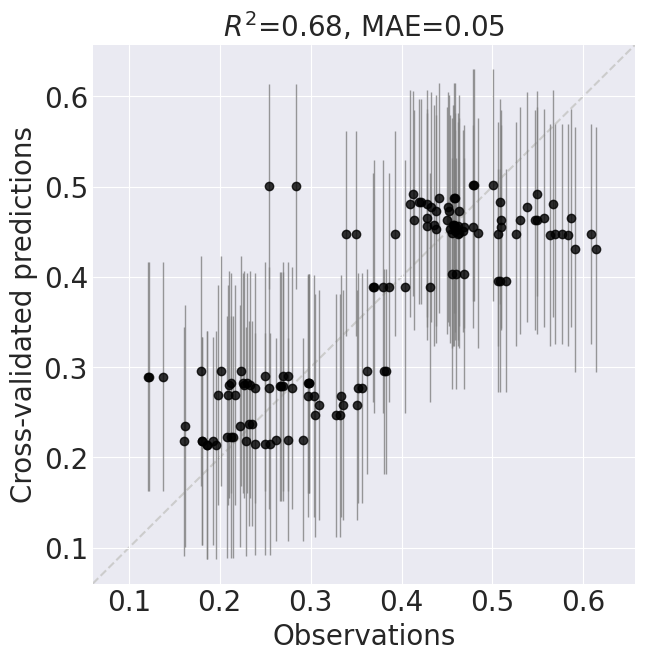

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RandomForestRegressor(PCA(input_matrix, iterated_power=7, svd_solver=randomized), bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=8, min_samples_split=18, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ExtraTreesRegressor(VarianceThreshold(input_matrix, threshold=0.005), bootstrap=True, max_features=0.8500000000000001, min_samples_leaf=2, min_samples_split=6, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: DecisionTreeRegressor(XGBRegressor(LassoLarsCV(input_matrix, normalize=True), learning_rate=0.001, max_depth=9, min_child_weight=17, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.35000000000000003, verbosity=0), max_depth=6, min_samples_leaf=4, min_samples_split=3)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(LassoLarsCV(OneHotEncoder(input_matrix, minimum_fraction=0.15, sparse=False, threshold=10), normalize=True), learning_rate=0.001, loss=linear, n_estimators=100)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Done fitting L0 models in 138.01 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Building ensemble model (4 sampling jobs)…


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, omegas]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.
/usr/local/art/.venv/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Done building ensemble model in 35.68 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.086918,27.035699,0.073945,0.013023,0.201257
Random Forest Regressor,0.018895,5.320545,0.019745,0.000747,0.954190
Support Vector Regressor,0.055044,17.991572,0.027525,0.003787,0.767700
Kernel Ridge Regressor,0.028669,8.044337,0.024085,0.001402,0.914010
K-NN Regressor,0.040640,13.156406,0.034593,0.002848,0.825300
Gaussian Process Regressor,0.019577,5.548965,0.019983,0.000783,0.952000
Gradient Boosting Regressor,0.018030,4.996205,0.019690,0.000713,0.956280
TPOT Regressor 1,0.026026,7.642518,0.023116,0.001212,0.925681
TPOT Regressor 2,0.024444,7.207789,0.022957,0.001124,0.931030


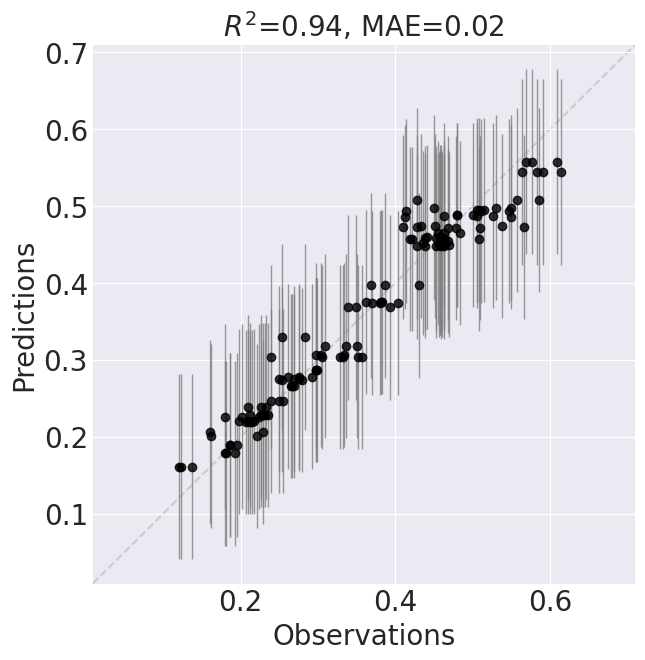

Done building models in 177.30 s


In [58]:
art = train_art(df_stacked, user_params, 'art_outliers_removed.cpkl')

In [59]:
def recommend_DE(art, user_params):
    def obj_func(x, art, draws):
        #print(x.shape)
        foo = art.post_pred_stats(x)
        #file1.write(str(x.flatten()[1:-1]))
        G = np.squeeze((1-art.alpha)*foo[0] +  art.alpha*foo[1])
        draws.append(np.append(x,G))

        return -G

    f = lambda x: obj_func(x,art, draws)
    draws = []
    result = differential_evolution(f, Bounds(art.bounds.values[:,0], art.bounds.values[:,1]), \
                                    maxiter = user_params['maxiter'], popsize= user_params['popsize'], vectorized = False)

    draws = np.array(draws) #make into a numpy array
    draws_padded = np.hstack((draws, np.reshape(draws[:,-1], [-1,1]))) # add an extra column in the end to achieve n_input_vars+2

    from art.core.recommender import Recommender

    recommender = Recommender(
                art.loader,
                art.create_bounds(),
                art._args,
                publish_recs=False,
                # ### Pass-through RE params  #######
                # self.input_vars,
                # self.num_recommendations,
                # self.output_dir,
                # self.rel_rec_distance,
                # self.response_vars,
                # self.testing,
                # self.verbose,
                # self.warning_callback,
            )
    recommendations = recommender.select(draws_padded)
    return recommendations

In [60]:
art.num_recommendations


16

In [61]:
from scipy.optimize import differential_evolution, Bounds
user_params['maxiter'] = 100
user_params['popsize'] = 500
art.alpha = user_params['alpha_explor']
art.num_recommendations = user_params['n_instances_explor']
art.rel_rec_distance = 2
recs_explore = recommend_DE(art, user_params)



Choosing recommendations (36,273 candidates)…


Done choosing recommendations in 0.55 s


In [62]:
recs_explore

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM]
0,0.045186,0.590637,4.413947,0.023892,47.480272,0.033098,651.233703,0.000541,0.003010,0.000536,0.007166,0.001252
1,0.034717,0.641054,4.219546,0.022366,40.901081,0.156846,719.688474,0.000335,0.003982,0.000275,0.008757,0.000690
2,0.060521,0.213610,4.231752,0.022273,31.848979,0.492975,782.078648,0.000481,0.003856,0.000222,0.007487,0.001706
3,0.031501,0.312703,4.210275,0.067582,44.136699,0.320089,472.095944,0.000427,0.000882,0.000137,0.012223,0.000856
4,0.030435,0.573867,4.605107,0.075394,39.729834,0.288319,527.577417,0.000533,0.001293,0.000479,0.005522,0.001418


In [63]:
# user_params['maxiter'] = 1000
# user_params['popsize'] = 500
art.alpha = user_params['alpha_exploit']
art.num_recommendations = user_params['n_instances_exploit']
recs_exploit = recommend_DE(art, user_params)

Choosing recommendations (115,365 candidates)…


Done choosing recommendations in 50.24 s


In [64]:
recs_exploit.head(10)


,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM]
0,0.006421,0.673537,4.557756,0.054778,9.943405,0.249469,458.885336,0.000175,0.001855,0.000260,0.002031,0.000254
1,0.008666,0.674731,4.101003,0.044203,10.293334,0.263730,496.593169,0.000175,0.001410,0.000100,0.006292,0.000207
2,0.008666,0.674731,4.275314,0.055751,10.293334,0.128261,449.824314,0.000142,0.001889,0.000466,0.006292,0.000207
3,0.011664,0.400558,4.712679,0.043881,10.689284,0.285026,497.991592,0.000153,0.001605,0.000463,0.003221,0.000783
4,0.005430,0.248592,4.194682,0.051710,10.086137,0.239106,445.886624,0.000157,0.000849,0.000281,0.010667,0.000638
5,0.004231,0.591610,5.083742,0.045033,10.083175,0.876155,455.774052,0.000211,0.002533,0.000212,0.001691,0.000314
6,0.012720,0.762141,6.489701,0.050776,10.564076,0.891038,456.485818,0.000170,0.001990,0.000059,0.003392,0.000252
7,0.014451,0.668507,4.284171,0.057786,11.409408,0.947277,444.830901,0.000171,0.001862,0.000480,0.000660,0.000760
8,0.017924,0.690362,3.544519,0.057062,11.180931,0.886672,492.153670,0.000229,0.002112,0.000474,0.002997,0.000219
9,0.009422,0.765774,3.926741,0.037959,12.684376,0.416545,460.648365,0.000129,0.002407,0.000314,0.011054,0.000472


In [65]:
mean_exploit, std_exploit = art.post_pred_stats(recs_exploit.values)
mean_explore, std_explore = art.post_pred_stats(recs_explore.values)
recs_explore['OD340_pred'] = mean_explore 
recs_explore['OD340_std'] = std_explore 

recs_exploit['OD340_pred'] = mean_exploit 
recs_exploit['OD340_std'] = std_exploit 

In [66]:
recs_explore['Label'] = 'explore'
recs_exploit['Label'] = 'exploit'

In [67]:
recs_explore



,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.045186,0.590637,4.413947,0.023892,47.480272,0.033098,651.233703,0.000541,0.003010,0.000536,0.007166,0.001252,0.465421,0.069538,explore
1,0.034717,0.641054,4.219546,0.022366,40.901081,0.156846,719.688474,0.000335,0.003982,0.000275,0.008757,0.000690,0.467617,0.069536,explore
2,0.060521,0.213610,4.231752,0.022273,31.848979,0.492975,782.078648,0.000481,0.003856,0.000222,0.007487,0.001706,0.464609,0.069371,explore
3,0.031501,0.312703,4.210275,0.067582,44.136699,0.320089,472.095944,0.000427,0.000882,0.000137,0.012223,0.000856,0.467679,0.069356,explore
4,0.030435,0.573867,4.605107,0.075394,39.729834,0.288319,527.577417,0.000533,0.001293,0.000479,0.005522,0.001418,0.469861,0.069294,explore


In [68]:
recs_exploit.head(10)



,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.006421,0.673537,4.557756,0.054778,9.943405,0.249469,458.885336,0.000175,0.001855,0.000260,0.002031,0.000254,0.565050,0.062589,exploit
1,0.008666,0.674731,4.101003,0.044203,10.293334,0.263730,496.593169,0.000175,0.001410,0.000100,0.006292,0.000207,0.557016,0.062407,exploit
2,0.008666,0.674731,4.275314,0.055751,10.293334,0.128261,449.824314,0.000142,0.001889,0.000466,0.006292,0.000207,0.556585,0.062279,exploit
3,0.011664,0.400558,4.712679,0.043881,10.689284,0.285026,497.991592,0.000153,0.001605,0.000463,0.003221,0.000783,0.553974,0.062078,exploit
4,0.005430,0.248592,4.194682,0.051710,10.086137,0.239106,445.886624,0.000157,0.000849,0.000281,0.010667,0.000638,0.541831,0.061539,exploit
5,0.004231,0.591610,5.083742,0.045033,10.083175,0.876155,455.774052,0.000211,0.002533,0.000212,0.001691,0.000314,0.539607,0.063089,exploit
6,0.012720,0.762141,6.489701,0.050776,10.564076,0.891038,456.485818,0.000170,0.001990,0.000059,0.003392,0.000252,0.536615,0.063723,exploit
7,0.014451,0.668507,4.284171,0.057786,11.409408,0.947277,444.830901,0.000171,0.001862,0.000480,0.000660,0.000760,0.533469,0.062293,exploit
8,0.017924,0.690362,3.544519,0.057062,11.180931,0.886672,492.153670,0.000229,0.002112,0.000474,0.002997,0.000219,0.532975,0.062612,exploit
9,0.009422,0.765774,3.926741,0.037959,12.684376,0.416545,460.648365,0.000129,0.002407,0.000314,0.011054,0.000472,0.532273,0.061813,exploit


In [69]:
df_target = pd.concat([recs_explore, recs_exploit]).reset_index()
df_target.rename(columns={'OD340': 'OD340_pred'}, inplace=True)



In [70]:
df_target = df_target.drop(columns=['index'])
df_target.head()



,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.045186,0.590637,4.413947,0.023892,47.480272,0.033098,651.233703,0.000541,0.003010,0.000536,0.007166,0.001252,0.465421,0.069538,explore
1,0.034717,0.641054,4.219546,0.022366,40.901081,0.156846,719.688474,0.000335,0.003982,0.000275,0.008757,0.000690,0.467617,0.069536,explore
2,0.060521,0.213610,4.231752,0.022273,31.848979,0.492975,782.078648,0.000481,0.003856,0.000222,0.007487,0.001706,0.464609,0.069371,explore
3,0.031501,0.312703,4.210275,0.067582,44.136699,0.320089,472.095944,0.000427,0.000882,0.000137,0.012223,0.000856,0.467679,0.069356,explore
4,0.030435,0.573867,4.605107,0.075394,39.729834,0.288319,527.577417,0.000533,0.001293,0.000479,0.005522,0.001418,0.469861,0.069294,explore


In [71]:
user_params['standard_media_file']



'../flaviolin data/standard_recipe_concentrations.csv'

In [72]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")
df_stand = df_stand.rename(columns = {"Concentration":'Concentration[mM]'} )
df_stand



,Concentration[mM],Solubility
Component,,
MOPS[mM],40.00000,1700.00
Tricine[mM],4.00000,500.08
H3BO3[mM],0.00400,700.00
Glucose[mM],20.00000,5045.63
K2SO4[mM],0.29000,636.98
K2HPO4[mM],1.32000,8564.84
FeSO4[mM],0.01000,1645.73
NH4Cl[mM],9.52000,6543.28
MgCl2[mM],0.52000,569.27


In [73]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration[mM]']
    df_control.at['Control', component] = stand_conc*np.random.uniform(lb, ub)

df_control

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM]
Control,0.004165,0.287965,1.387221,0.0103,10.109658,0.517059,51.122061,0.000031,0.000287,0.000101,0.000851,0.000095


In [74]:
for component in user_params['components'][:-1]:
     assert(all(df_control.at['Control', component] != control_lines[component]))

In [75]:
control_predicted_mean, control_predicted_std = art.post_pred_stats(
            df_control.values
        )
df_control['OD340_pred'] = control_predicted_mean
df_control['OD340_std'] = control_predicted_std
df_control['Label'] = 'standard'

In [76]:
df_control

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
Control,0.004165,0.287965,1.387221,0.0103,10.109658,0.517059,51.122061,0.000031,0.000287,0.000101,0.000851,0.000095,0.275691,0.061074,standard


In [111]:
control_lines = df[df['Line Name'].str.find('_F8') > 0]
print(control_lines)
print(control_lines.index)

Measurement Type       Line Name   OD340 MOPS[mM] Tricine[mM] H3BO3[mM]  \
42                  C1_WF6_F8-R1  0.2973     40.0         4.0  0.003902   
43                  C1_WF6_F8-R2  0.2982     40.0         4.0  0.003902   
44                  C1_WF6_F8-R3  0.2978     40.0         4.0  0.003902   
87                C2.1_WF6_F8-R1  0.2537     40.0         4.0   0.00435   
88                C2.1_WF6_F8-R3  0.2794     40.0         4.0   0.00435   
131               C3.1_WD8_F8-R1  0.2499     40.0         4.0   0.00409   
132               C3.1_WD8_F8-R2  0.2753     40.0         4.0   0.00409   
133               C3.1_WD8_F8-R3  0.2692     40.0         4.0   0.00409   

Measurement Type Glucose[mM] K2SO4[mM] K2HPO4[mM] FeSO4[mM] NH4Cl[mM]  \
42                      20.0  0.317207   1.312346  0.009853  9.731379   
43                      20.0  0.317207   1.312346  0.009853  9.731379   
44                      20.0  0.317207   1.312346  0.009853  9.731379   
87                      20.0  0.

In [112]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']
print(df_train.loc[control_lines.index,:])
df_train


Measurement Type H3BO3[mM] K2SO4[mM] K2HPO4[mM] FeSO4[mM] NH4Cl[mM] MgCl2[mM]  \
42                0.003902  0.317207   1.312346  0.009853  9.731379  0.548221   
43                0.003902  0.317207   1.312346  0.009853  9.731379  0.548221   
44                0.003902  0.317207   1.312346  0.009853  9.731379  0.548221   
87                 0.00435  0.316635   1.373984  0.009343  9.152222  0.515452   
88                 0.00435  0.316635   1.373984  0.009343  9.152222  0.515452   
131                0.00409    0.3158   1.395181  0.009462  9.766629  0.543018   
132                0.00409    0.3158   1.395181  0.009462  9.766629  0.543018   
133                0.00409    0.3158   1.395181  0.009462  9.766629  0.543018   

Measurement Type   NaCl[mM] (NH4)6Mo7O24[mM] CoCl2[mM] CuSO4[mM] MnSO4[mM]  \
42                54.873776         0.000027  0.000272    0.0001    0.0008   
43                54.873776         0.000027  0.000272    0.0001    0.0008   
44                54.873776         

/tmp/ipykernel_85702/1247666182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OD340'] = df['OD340']


Measurement Type,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340
0,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.2076
1,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.2149
2,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.2124
3,0.003918,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.1955
4,0.003918,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.1859
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.012305,0.795866,2.123382,0.049167,10.839289,0.510871,386.600976,0.000022,0.000946,0.001125,0.013717,0.001156,0.5667
130,0.012305,0.795866,2.123382,0.049167,10.839289,0.510871,386.600976,0.000022,0.000946,0.001125,0.013717,0.001156,0.4280
131,0.00409,0.3158,1.395181,0.009462,9.766629,0.543018,52.665395,0.00003,0.000309,0.000103,0.000764,0.000106,0.2499
132,0.00409,0.3158,1.395181,0.009462,9.766629,0.543018,52.665395,0.00003,0.000309,0.000103,0.000764,0.000106,0.2753


In [113]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )
df_train['OD340_pred'] = train_predicted_mean
df_train['OD340_std'] = train_predicted_std
df_train['OD340_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['OD340_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]
df_train['Label'] = 'train'
df_train.loc[control_lines.index, 'Label'] = 'standard'

/tmp/ipykernel_85702/3599349876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OD340_pred'] = train_predicted_mean
/tmp/ipykernel_85702/3599349876.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OD340_std'] = train_predicted_std
/tmp/ipykernel_85702/3599349876.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

Measurement Type,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340,OD340_pred,OD340_std,OD340_cv_pred,OD340_cv_std,Label
42,0.003902,0.317207,1.312346,0.009853,9.731379,0.548221,54.873776,0.000027,0.000272,0.0001,0.0008,0.0001,0.2973,0.287258,0.061053,0.282165,0.061745,standard
43,0.003902,0.317207,1.312346,0.009853,9.731379,0.548221,54.873776,0.000027,0.000272,0.0001,0.0008,0.0001,0.2982,0.287258,0.061053,0.282165,0.061745,standard
44,0.003902,0.317207,1.312346,0.009853,9.731379,0.548221,54.873776,0.000027,0.000272,0.0001,0.0008,0.0001,0.2978,0.287258,0.061053,0.282165,0.061745,standard
87,0.00435,0.316635,1.373984,0.009343,9.152222,0.515452,52.58102,0.000031,0.000325,0.0001,0.0008,0.0001,0.2537,0.273665,0.061072,0.277186,0.068279,standard
88,0.00435,0.316635,1.373984,0.009343,9.152222,0.515452,52.58102,0.000031,0.000325,0.0001,0.0008,0.0001,0.2794,0.273665,0.061072,0.277186,0.068279,standard
131,0.00409,0.3158,1.395181,0.009462,9.766629,0.543018,52.665395,0.00003,0.000309,0.000103,0.000764,0.000106,0.2499,0.275735,0.061077,0.289741,0.064912,standard
132,0.00409,0.3158,1.395181,0.009462,9.766629,0.543018,52.665395,0.00003,0.000309,0.000103,0.000764,0.000106,0.2753,0.275735,0.061077,0.289741,0.064912,standard
133,0.00409,0.3158,1.395181,0.009462,9.766629,0.543018,52.665395,0.00003,0.000309,0.000103,0.000764,0.000106,0.2692,0.275735,0.061077,0.289741,0.064912,standard


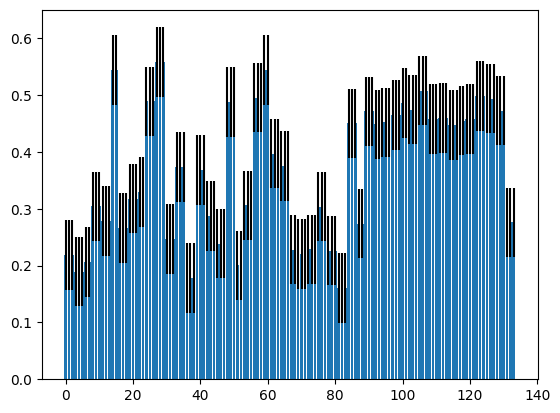

In [99]:
# df_train_no_duplicates = df_train.loc[list(range(2, 143, 3))]
#df_train_no_duplicates['OD340_pred'].plot.bar( yerr = df_train_no_duplicates['OD340_std'])
#plt.show()
fig, ax = plt.subplots()
ax.bar(df_train.index, df_train['OD340_pred'], yerr =df_train['OD340_std'] )
plt.show()

In [100]:

df_target_plot = pd.concat([recs_explore, recs_exploit]).reset_index()
df_target_plot.rename(columns={'OD340': 'OD340_pred'}, inplace=True)
df_target_plot = pd.concat([df_target_plot,df_control]).reset_index(drop=True)

df_target_plot.head()

,index,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.0,0.045186,0.590637,4.413947,0.023892,47.480272,0.033098,651.233703,0.000541,0.00301,0.000536,0.007166,0.001252,0.465421,0.069538,explore
1,1.0,0.034717,0.641054,4.219546,0.022366,40.901081,0.156846,719.688474,0.000335,0.003982,0.000275,0.008757,0.00069,0.467617,0.069536,explore
2,2.0,0.060521,0.21361,4.231752,0.022273,31.848979,0.492975,782.078648,0.000481,0.003856,0.000222,0.007487,0.001706,0.464609,0.069371,explore
3,3.0,0.031501,0.312703,4.210275,0.067582,44.136699,0.320089,472.095944,0.000427,0.000882,0.000137,0.012223,0.000856,0.467679,0.069356,explore
4,4.0,0.030435,0.573867,4.605107,0.075394,39.729834,0.288319,527.577417,0.000533,0.001293,0.000479,0.005522,0.001418,0.469861,0.069294,explore


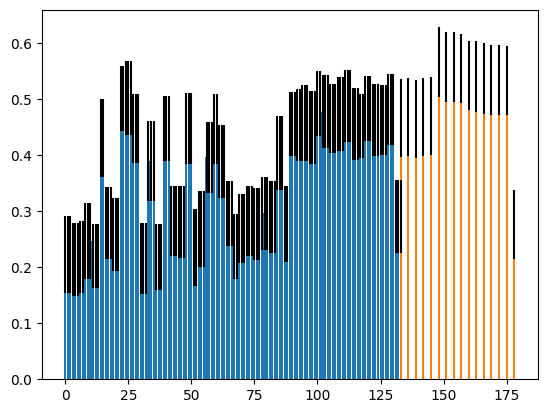

In [101]:
fig, ax = plt.subplots()
ax.bar(df_train.index, df_train['OD340_cv_pred'], 
       yerr =df_train['OD340_cv_std'] )
ax.bar(df_target_plot.index*3+max(df_train.index), df_target_plot['OD340_pred'], 
       yerr = df_target_plot['OD340_std'] )
plt.show()

In [116]:
file = f"{user_params['output_dir']}/train_pred.csv"
df_train.to_csv(file)
df_target = pd.concat([df_target,df_control]).reset_index(drop=True)

In [103]:
df_target

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.045186,0.590637,4.413947,0.023892,47.480272,0.033098,651.233703,0.000541,0.00301,0.000536,0.007166,0.001252,0.465421,0.069538,explore
1,0.045186,0.590637,4.413947,0.023892,47.480272,0.033098,651.233703,0.000541,0.00301,0.000536,0.007166,0.001252,0.465421,0.069538,explore
2,0.045186,0.590637,4.413947,0.023892,47.480272,0.033098,651.233703,0.000541,0.00301,0.000536,0.007166,0.001252,0.465421,0.069538,explore
3,0.034717,0.641054,4.219546,0.022366,40.901081,0.156846,719.688474,0.000335,0.003982,0.000275,0.008757,0.00069,0.467617,0.069536,explore
4,0.034717,0.641054,4.219546,0.022366,40.901081,0.156846,719.688474,0.000335,0.003982,0.000275,0.008757,0.00069,0.467617,0.069536,explore
5,0.034717,0.641054,4.219546,0.022366,40.901081,0.156846,719.688474,0.000335,0.003982,0.000275,0.008757,0.00069,0.467617,0.069536,explore
6,0.060521,0.21361,4.231752,0.022273,31.848979,0.492975,782.078648,0.000481,0.003856,0.000222,0.007487,0.001706,0.464609,0.069371,explore
7,0.060521,0.21361,4.231752,0.022273,31.848979,0.492975,782.078648,0.000481,0.003856,0.000222,0.007487,0.001706,0.464609,0.069371,explore
8,0.060521,0.21361,4.231752,0.022273,31.848979,0.492975,782.078648,0.000481,0.003856,0.000222,0.007487,0.001706,0.464609,0.069371,explore
9,0.031501,0.312703,4.210275,0.067582,44.136699,0.320089,472.095944,0.000427,0.000882,0.000137,0.012223,0.000856,0.467679,0.069356,explore


In [91]:
df_target = df_target.loc[df_target.index.repeat(user_params['n_replicates'])]
df_target

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.045186,0.590637,4.413947,0.023892,47.480272,0.033098,651.233703,0.000541,0.00301,0.000536,0.007166,0.001252,0.465421,0.069538,explore
0,0.045186,0.590637,4.413947,0.023892,47.480272,0.033098,651.233703,0.000541,0.00301,0.000536,0.007166,0.001252,0.465421,0.069538,explore
0,0.045186,0.590637,4.413947,0.023892,47.480272,0.033098,651.233703,0.000541,0.00301,0.000536,0.007166,0.001252,0.465421,0.069538,explore
1,0.034717,0.641054,4.219546,0.022366,40.901081,0.156846,719.688474,0.000335,0.003982,0.000275,0.008757,0.00069,0.467617,0.069536,explore
1,0.034717,0.641054,4.219546,0.022366,40.901081,0.156846,719.688474,0.000335,0.003982,0.000275,0.008757,0.00069,0.467617,0.069536,explore
1,0.034717,0.641054,4.219546,0.022366,40.901081,0.156846,719.688474,0.000335,0.003982,0.000275,0.008757,0.00069,0.467617,0.069536,explore
2,0.060521,0.21361,4.231752,0.022273,31.848979,0.492975,782.078648,0.000481,0.003856,0.000222,0.007487,0.001706,0.464609,0.069371,explore
2,0.060521,0.21361,4.231752,0.022273,31.848979,0.492975,782.078648,0.000481,0.003856,0.000222,0.007487,0.001706,0.464609,0.069371,explore
2,0.060521,0.21361,4.231752,0.022273,31.848979,0.492975,782.078648,0.000481,0.003856,0.000222,0.007487,0.001706,0.464609,0.069371,explore
3,0.031501,0.312703,4.210275,0.067582,44.136699,0.320089,472.095944,0.000427,0.000882,0.000137,0.012223,0.000856,0.467679,0.069356,explore


In [92]:
well_rows = 'ABCDEF'
well_columns = '12345678'
well_names = [f'{row}{column}'  for column in well_columns for row in well_rows]

df_target['Well'] = well_names
df_target = df_target.set_index(['Well'])
df_target.head()

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
Well,,,,,,,,,,,,,,,
A1,0.045186,0.590637,4.413947,0.023892,47.480272,0.033098,651.233703,0.000541,0.00301,0.000536,0.007166,0.001252,0.465421,0.069538,explore
B1,0.045186,0.590637,4.413947,0.023892,47.480272,0.033098,651.233703,0.000541,0.00301,0.000536,0.007166,0.001252,0.465421,0.069538,explore
C1,0.045186,0.590637,4.413947,0.023892,47.480272,0.033098,651.233703,0.000541,0.00301,0.000536,0.007166,0.001252,0.465421,0.069538,explore
D1,0.034717,0.641054,4.219546,0.022366,40.901081,0.156846,719.688474,0.000335,0.003982,0.000275,0.008757,0.00069,0.467617,0.069536,explore
E1,0.034717,0.641054,4.219546,0.022366,40.901081,0.156846,719.688474,0.000335,0.003982,0.000275,0.008757,0.00069,0.467617,0.069536,explore


In [93]:
f"{user_params['output_dir']}/target_concentrations.csv"


'../flaviolin data/DBTL4.2/target_concentrations.csv'

In [94]:
file = f"{user_params['output_dir']}/target_concentrations.csv"
df_target.to_csv(file) 

In [ ]:
art.recommend()

In [ ]:
art.alpha

In [ ]:
user_params['n_instances_exploit'] = 8

In [ ]:
df_recs_exploit = art.recommendations.iloc[:user_params['n_instances_exploit'],:]

In [ ]:
df_recs_exploit

In [ ]:
art.recommendation_stats

In [ ]:
recs_exploit_stats = art.recommendation_stats.copy()
for key in recs_exploit_stats.keys():
    recs_exploit_stats[key] = recs_exploit_stats[key][:user_params['n_instances_exploit']]

In [ ]:
recs_exploit_stats

In [ ]:
df_recs_exploit['OD340'] = np.array(recs_exploit_stats['prediction_mean']).flatten()
df_recs_exploit['OD340_std'] = np.array(recs_exploit_stats['prediction_std']).flatten()
df_recs_exploit['Label'] = 'exploit'

In [ ]:
df_recs_exploit

In [ ]:
art.alpha = 0.8

In [ ]:
art.recommend()

In [ ]:
user_params['n_instances_explore'] = 7

In [ ]:
df_recs_explore = art.recommendations.iloc[:user_params['n_instances_explore'],:]

In [ ]:
df_recs_explore

In [ ]:
plt.scatter(art.X[:,6], art.y)
plt.show()

In [ ]:
plt.scatter(art.X[:,2], art.y)
plt.show()

In [ ]:
art.recommendation_stats

In [ ]:
recs_explore_stats = art.recommendation_stats.copy()
for key in recs_explore_stats.keys():
    recs_explore_stats[key] = recs_explore_stats[key][:user_params['n_instances_explore']]

In [ ]:
recs_explore_stats

In [95]:
df_recs_explore['OD340'] = np.array(recs_explore_stats['prediction_mean']).flatten()
df_recs_explore['OD340_std'] = np.array(recs_explore_stats['prediction_std']).flatten()
df_recs_explore['Label'] = 'explore'


NameError: name 'recs_explore_stats' is not defined

In [ ]:
df_recs_explore

In [ ]:
fig, ax = plt.subplots()
ax.bar(range(art.X.shape[0]),art.predict(art.X).flatten(), label = 'training data predictions')
ax.bar(range(art.X.shape[0], art.X.shape[0]+user_params['n_instances_exploit']), np.array(recs_exploit_stats['prediction_mean']).flatten(), label = 'exploit recs predictions')
ax.bar(range(art.X.shape[0]+user_params['n_instances_exploit'],art.X.shape[0]+user_params['n_instances_exploit']+user_params['n_instances_explore'])\
        , np.array(recs_explore_stats['prediction_mean']).flatten(), label = 'explore recs predictions')
#ax.legend()
plt.show()
fig.savefig(user_params['output_dir']+'/rec_bar_graph_outlier_removed.png')

In [ ]:
df_target = pd.concat([df_recs_explore, df_recs_exploit]).reset_index()
df_target.rename(columns={'OD340': 'OD340_pred'}, inplace=True)

In [ ]:
df_target

In [ ]:
user_params['standard_media_file']

In [ ]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")
df_stand = df_stand.rename(columns = {"Concentration":'Concentration[mM]'} )
df_stand

In [ ]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration[mM]']
    df_control.at['Control', component] = stand_conc*np.random.uniform(lb, ub)

df_control

In [ ]:
for component in user_params['components'][:-1]:
     assert(all(df_control.at['Control', component] != control_lines[component]))

In [ ]:
control_predicted_mean, control_predicted_std = art.post_pred_stats(
            df_control.values
        )
df_control['OD340_pred'] = control_predicted_mean
df_control['OD340_std'] = control_predicted_std
df_control['Label'] = 'standard'

In [ ]:
df_control

In [ ]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']
df_train

In [ ]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )
df_train['OD340_pred'] = train_predicted_mean
df_train['OD340_std'] = train_predicted_std
# df_train['OD340_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
# df_train['OD340_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]
df_train['Label'] = 'train'
df_train.loc[control_lines.index, 'Label'] = 'standard'

In [ ]:
df_train

In [ ]:
file = f"{user_params['output_dir']}/train_pred.csv"
df_train.to_csv(file)
df_target = pd.concat([df_target,df_control]).reset_index(drop=True)

In [ ]:
df_target

In [ ]:
df_target = df_target.loc[df_target.index.repeat(user_params['n_replicates'])]
df_target

In [ ]:
well_rows = 'ABCDEF'
well_columns = '12345678'
well_names = [f'{row}{column}'  for column in well_columns for row in well_rows]

df_target['Well'] = well_names
df_target = df_target.set_index(['Well'])
df_target.head()

In [ ]:
file = f"{user_params['output_dir']}/target_concentrations_x100_outlier_removed.csv"
df_target.to_csv(file) 

In [ ]:
import cloudpickle as cpickle
with open('../flaviolin data/DBTL7/art.cpkl', "rb") as input_file:
    art_loaded = cpickle.load(input_file)

In [ ]:
dfc1 = df[df['Line Name'].str.startswith('C1')]
dfc2 = df[df['Line Name'].str.startswith('C2')]

In [ ]:
x_dbtl1 = dfc1[user_params['components']]
y_dbtl1 = dfc1['OD340']
y_dbtl1_pred = art_loaded.predict(x_dbtl1)

x_dbtl2 = dfc2[user_params['components']]
y_dbtl2 = dfc2['OD340']
y_dbtl2_pred = art_loaded.predict(x_dbtl2)

In [ ]:
y_c1_c5 = art_loaded.y
X_c1_c5 = art_loaded.X
y_c1_c5_pred = art_loaded.predict(X_c1_c5)


plt.scatter(y_c1_c5, y_c1_c5_pred, color='black', label = 'training data DBTL 1-5')
plt.scatter(y_dbtl1, y_dbtl1_pred, color='red', label = 'new data DBTL 1')
plt.scatter(y_dbtl2, y_dbtl2_pred, color='green', label = 'new data DBTL 2')
plt.legend()
plt.plot([.1, .7],[.1, .7])
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('Trained on old data DBTL1-5 generated by Matt')
plt.show()


In [ ]:
x_dbtl1 = dfc1[user_params['components']]
y_dbtl1 = dfc1['OD340']
y_dbtl1_pred = art.predict(x_dbtl1)

x_dbtl2 = dfc2[user_params['components']]
y_dbtl2 = dfc2['OD340']
y_dbtl2_pred = art.predict(x_dbtl2)

y_c1_c5 = art_loaded.y
X_c1_c5 = art_loaded.X
y_c1_c5_pred = art.predict(X_c1_c5)


plt.scatter(y_c1_c5, y_c1_c5_pred, color='black', label = 'Old data DBTL 1-5')
plt.scatter(y_dbtl1, y_dbtl1_pred, color='red', label = 'training DBTL 1')
plt.scatter(y_dbtl2, y_dbtl2_pred, color='green', label = 'training DBTL 2')
plt.legend()
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('Trained on new data DBTL1-2 generated by Apostolos')

plt.plot([.1, .7],[.1, .7])
plt.show()

In [ ]:
art.parallel_tempering_opt()art.parallel_tempering_opt()

In [ ]:
draws = np.loadtxt('../flaviolin data/DBTL7/draws.txt')
art.recommend(draws[:,:-2])

In [ ]:
for i in range(len(art.input_vars)):
    x = range(draws.shape[0])
    y = draws[:,i]
    fig, ax = plt.subplots()
    sc = ax.scatter(x,y, c = draws[:,-4])
    ax.set_title(art.input_vars[i])
    ax.set_xlabel('Draws')
    ax.set_ylabel('Concentration[mM]')
    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel('OD340')

In [ ]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']
df_train['label'] = 'train'
df_rec = art.recommendations
df_rec['label'] = 'exploitation recommendations'
df_all = pd.concat([df_train, df_rec])

fig,ax = plt.subplots()
ax.bar(df_train.index, df_train['OD340'], label = 'DBTL1-6 train')
ax.bar(df_rec.index+max(df_train.index), df_rec['OD340'], label  = 'DBTL7 recommendations')
ax.set_ylabel('OD340')
ax.legend()

In [ ]:
draws_filename = f'draws_no_scale_input_scale_x1.txt'
alpha = .2#user_params['alpha_explor']
n_recs = user_params['n_instances_explor']
user_params['n_iter'] = 1e5
rel_rec_distance = 0.2
art, draws = generate_recommendations(art, user_params, draws_filename, alpha, n_recs, rel_rec_distance)


In [ ]:
art.num_recommendations = 15
art.rel_rec_distance = .5
art.recommend(draws)

In [ ]:
plot.draws_pc(art, draws, plot_scale_factor=100, plot_draws=True, plot_kde=False)


In [ ]:
plot.recommendations_pc(art, plot_scale_factor=100)


In [ ]:
df_target = art.recommendations.copy()
df_target.head()

In [ ]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_target.values[:, :-1]
        )

df_target['OD340_std'] = predicted_std
df_target['Label'] = 'exploration'
df_target.rename(columns={'OD340': 'OD340_pred'}, inplace=True)

In [ ]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")
df_stand = df_stand.rename(columns = {"Concentration":'Concentration[mM]'} )
df_stand

In [ ]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration[mM]']
    df_control.at['Control', component] = stand_conc*np.random.uniform(lb, ub)

df_control

In [ ]:
for component in user_params['components'][:-1]:
     assert(all(df_control.at['Control', component] != control_lines[component]))

In [ ]:
control_predicted_mean, control_predicted_std = art.post_pred_stats(
            df_control.values
        )
df_control['OD340_pred'] = control_predicted_mean
df_control['OD340_std'] = control_predicted_std
df_control['Label'] = 'standard'

In [ ]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']
df_train

In [ ]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )
df_train['OD340_pred'] = train_predicted_mean
df_train['OD340_std'] = train_predicted_std
#df_train['OD340_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
#df_train['OD340_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]
df_train['Label'] = 'train'
df_train.loc[control_lines.index, 'Label'] = 'standard'

In [ ]:
df_train.max()

In [ ]:
file = f"{user_params['output_dir']}/train_pred.csv"
df_train.to_csv(file)
df_target = df_target.append(df_control).reset_index(drop=True)

In [ ]:
df_target.head()

In [ ]:
df_target = df_target.loc[df_target.index.repeat(user_params['n_replicates'])]


In [ ]:
well_rows = 'ABCDEF'
well_columns = '12345678'
well_names = [f'{row}{column}'  for column in well_columns for row in well_rows]

df_target['Well'] = well_names
df_target = df_target.set_index(['Well'])
df_target.head()

In [ ]:
df_target

In [ ]:
file = f"{user_params['output_dir']}/target_concentrations.csv"
df_target.to_csv(file) 